# Домашнее задание 3

## Попытка использовать requests

In [40]:
import requests  
#адрес url был взят по запросу "quantum physics" наиболее используемых статей в базе данных Web of Science с сортировкой по убыванию
url = "https://www.webofscience.com/wos/woscc/summary/75bb3d08-9aa4-4755-b49d-c953a4cea9a6-600a4a06/usage-count-descending"
response = requests.get(url)
response

<Response [403]>

🦊 403 - доступ к запрошенному ресурсу запрещен 

## Использую selenium

In [5]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select

In [26]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

driver = webdriver.Chrome(ChromeDriverManager().install())

/tmp/ipykernel_24452/2160715986.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


### Импортирую необходимые библиотеки

In [4]:
import time
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from tqdm import tqdm

### Сохраняем все html страницы в файлы, всего семь страниц по 50 объектов

**Пример загрузки начальной страницы с поиском**

<img src="data/screens/main_page.png" height="300" width="1200"> 

**Пример загрузки страницы со специальной сортировкой**

<img src="data/screens/sorted_page.png" height="300" width="1200"> 

## Загрузка страниц с помощью драйвера

In [27]:
url = "https://www.webofscience.com/wos/woscc/summary/2f3cdd30-96b9-48ff-8a9a-2d6578ea1c57-60f00253/usage-count-descending"
sleepings = [6, 3, 7, 5, 10, 4, 8]
for i in tqdm(range(7)):
    driver.get(f'{url}/{i + 1}')
    time.sleep(5)
    for count in range(23):
        body = driver.find_element("css selector","body")
        #для загрузки всех данных со страницы следующая команда не сработала - перейти к концу страницы
        #driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        body.send_keys(Keys.PAGE_DOWN)
        #с командой page_down загружаются по 2-3 объекта таблицы
        time.sleep(4)
    #после загрузки всего html записываю данные в переменную
    html = driver.page_source
    #потом в файлы
    f = open(f'data/html/webofscience_quantum_physics_{i * 50 + 1}-{i * 50 + 50}.txt', "w")
    time.sleep(sleepings[i])
    f.write(str(html))
    f.close()

100%|████████████████████████████████████████████| 7/7 [12:35<00:00, 107.89s/it]


### Парсим данные из файлов

In [18]:
data_dict = {}
data_dict['title'] = []
data_dict['authors'] = []
data_dict['date'] = []
data_dict['journal'] = []
data_dict['volume'] = []
data_dict['issue'] = []
data_dict['pp'] = []
data_dict['citations'] = []
data_dict['references'] = []
data_dict['paper_link'] = []
for i in tqdm(range(7)):
    f = open(f'data/html/webofscience_quantum_physics_{i * 50 + 1}-{i * 50 + 50}.txt', "r")
    tree = BeautifulSoup(f.read())
    title = tree.find_all("a", {"class": "title title-link font-size-18 ng-star-inserted"}, href=True)
    authors = []
    for k in range(50):
        first = tree.find("a", {"data-ta": f"SumAuthTa-{k}-DisplayName-author-en-0"})
        second = tree.find('a', {'data-ta': f'SumAuthTa-{k}-DisplayName-author-en-1'})
        third = tree.find('a', {'data-ta': f'SumAuthTa-{k}-DisplayName-author-en-2'})
        fourth = tree.find('a', {'data-ta': f'SumAuthTa-{k}-DisplayName-author-en-3'})
        if (first != None):
            if (third):
                authors.append(' '.join([first.text, second.text, third.text]))
            else:
                if (fourth):
                    authors.append(' '.join([first.text, second.text, '...', fourth.text]))
                else:
                    if (second):
                        authors.append(' '.join([first.text, second.text]))
                    else: authors.append(' '.join([first.text]))
    date = tree.find_all('span', {'name': "pubdate"})
    journal = tree.find_all('a', {'class': 'mat-focus-indicator mat-tooltip-trigger font-size-14 summary-source-title-link no-left-padding mat-button mat-button-base mat-primary ng-star-inserted'})
    volume = tree.find_all('span', {'data-ta': "Summary-vol"})
    pp = tree.find_all('span', {'data-ta': "Summary-page-no"})
    issue = tree.find_all('span', {'data-ta': "Summary-issue"})
    citations = tree.find_all('a',{"data-ta": "stat-number-citation-related-count"})
    references = tree.find_all('a', {'data-ta': "stat-number-references-count"})
    data_dict['title'].extend([el.text for el in title])
    data_dict['authors'].extend(authors)
    data_dict['date'].extend([el.text[:-3] for el in date])
    data_dict['journal'].extend([el.text for el in journal])
    data_dict['volume'] = [el.text for el in volume]
    data_dict['issue'].extend([el.text for el in issue])
    data_dict['pp'].extend([el.text for el in pp])
    data_dict['citations'].extend([int(''.join(el.text.split(','))) for el in citations])
    data_dict['references'].extend([int(''.join(el.text.split(','))) for el in references])
    data_dict['paper_link'].extend([el['href'] for el in title])

100%|█████████████████████████████████████████████| 7/7 [00:16<00:00,  2.37s/it]


In [19]:
col_names = ['title', 'authors', 'date', 'journal', 'citations', 'references', 'paper_link']
df = pd.DataFrame(list(zip(data_dict['title'], data_dict['authors'], data_dict['date'], data_dict['journal'],
                           data_dict['citations'], data_dict['references'], data_dict['paper_link'])), columns = col_names)
df.to_csv('data/table.csv')
df

,title,authors,date,journal,citations,references,paper_link
0,The rise of graphene,"Geim, AK Novoselov, KS",Mar 2007,NATURE MATERIALS,32119,91,/wos/woscc/full-record/WOS:000244570700015
1,The electronic properties of graphene,"Castro Neto, AH Guinea, F ... Geim, AK",Jan-mar 2009,REVIEWS OF MODERN PHYSICS,18556,440,/wos/woscc/full-record/WOS:000264764600004
2,Generalized gradient approximation made simple,"Perdew, JP Burke, K Ernzerhof, M",Oct 28 1996,PHYSICAL REVIEW LETTERS,126241,47,/wos/woscc/full-record/WOS:A1996VP22500044
3,Two-dimensional gas of massless Dirac fermions...,"Novoselov, KS Geim, AK ... Firsov, AA",Nov 10 2005,NATURE,16881,28,/wos/woscc/full-record/WOS:000233133500042
4,Large-scale pattern growth of graphene films f...,"Kim, KS Zhao, Y ... Hong, BH",Feb 5 2009,NATURE,8186,30,/wos/woscc/full-record/WOS:000263064700037
...,...,...,...,...,...,...,...
345,Photo/Electrochemical Applications of Metal Su...,"Zheng, LX Teng, F ... Fang, XS",Jan 2020,ADVANCED ENERGY MATERIALS,160,328,/wos/woscc/full-record/WOS:000497581000001
346,Hydrogen storage in Pd nanocrystals covered wi...,"Li, GQ Kobayashi, H ... Kitagawa, H",Aug 2014,NATURE MATERIALS,327,24,/wos/woscc/full-record/WOS:000339647800020
347,Photoluminescence Properties of Graphene versu...,"Cao, L Meziani, MJ ... Sun, YP",Jan 15 2013,ACCOUNTS OF CHEMICAL RESEARCH,588,42,/wos/woscc/full-record/WOS:000313667600018
348,Group 6 transition metal dichalcogenide nanoma...,"Samadi, M Sarikhani, N ... Moshfegh, AZ",Mar 2018,NANOSCALE HORIZONS,208,1221,/wos/woscc/full-record/WOS:000433439100002


~~Добавление информации об авторах и адресах с помощью перехода по ссылке на каждую статью через клик на ссылку

😔 *не получилось, так как при возвращении на исходную страницу в истории загружается первый блок статей, а не текущий*

In [ ]:
# authors = []
# affiliation = []
# for i in range(7):
#     driver.get(f'{url}/{i + 1}')
#     time.sleep(5)
#     for count in range(50):
#         fld = driver.find_element("xpath",f'/html/body/app-wos/main/div/div/div[2]/div/div/div[2]/app-input-route/app-base-summary-component/div[2]/div/app-records-list/app-record[{count + 1}]/div/div/div[2]/div[1]/app-summary-title/h3/a')
#         fld.click()
#         time.sleep(5)
#         html = driver.page_source
#         tree = BeautifulSoup(html)
#         authors.extend(tree.find_all('div', {'id': "SumAuthTa-MainDiv-author-en"}))
#         affiliation.extend(tree.find_all('span', {"class": "value padding-right-5--reversible"}))
#         driver.back()
#         body = driver.find_element("css selector",'body')
#         body.send_keys(Keys.PAGE_DOWN)
#         time.sleep(5)

### Парсим данные каждой статьи по ссылкам (полный список авторов и организаций)

🐸 *Данные об учебных заведениях или научных центрах авторов содержатся только на странице с описанием статьи и этой информации нет в общей таблице*

🐸*Также в общей таблице приведен не весь список авторов, а только три автора, если авторов >= 4, тогда приводятся только первые два и самый последний. Поэтому эту информацию требуется взять переходя по ссылке на каждую статью.*

In [11]:
url = "https://www.webofscience.com"
df = pd.read_csv("data/table.csv")
paper_link = df.loc[:,"paper_link"]
authors = []
affiliation = []
for i in tqdm(range(350)):
    driver.get(f'{url}{paper_link[i]}')
    time.sleep(4)
    html = driver.page_source
    tree = BeautifulSoup(html)
    findings_authors = tree.find_all('a', {'class': "mat-tooltip-trigger authors value ng-star-inserted"})
    authors.append([el.text for el in findings_authors])
    findings_affiliation = tree.find_all('span', {"class": "value padding-right-5--reversible"})
    affiliation.append([el.text for el in findings_affiliation])
driver.close()

100%|█████████████████████████████████████████| 350/350 [33:37<00:00,  5.77s/it]


In [ ]:
authors_joined = []
affiliation_joined = []
for el in authors:
    authors_joined.append('; '.join(el))
for el in affiliation:
    affiliation_joined.append('; '.join(el))
df = pd.DataFrame(list(zip(authors_joined, affiliation_joined)), columns=['authors_full', 'affiliation'])
df.to_csv('data/authors_full+affiliation.csv')

### Добавляем два столбца authors_full и affiliation в датафрейм и в файл table.csv

In [20]:
dfaa = pd.read_csv('data/authors_full+affiliation.csv')
df = df.assign(authors_full=dfaa['authors_full'])
df = df.assign(affiliation=dfaa['affiliation'])
df.to_csv('data/table.csv')
df

,title,authors,date,journal,citations,references,paper_link,authors_full,affiliation
0,The rise of graphene,"Geim, AK Novoselov, KS",Mar 2007,NATURE MATERIALS,32119,91,/wos/woscc/full-record/WOS:000244570700015,"Geim, AK; Novoselov, KS","Univ Manchester, Manchester Ctr Mesosci & Nano..."
1,The electronic properties of graphene,"Castro Neto, AH Guinea, F ... Geim, AK",Jan-mar 2009,REVIEWS OF MODERN PHYSICS,18556,440,/wos/woscc/full-record/WOS:000264764600004,"Castro Neto, AH; Guinea, F; Peres, NMR; Novose...","Boston Univ, Dept Phys, Boston, MA 02215 USA; ..."
2,Generalized gradient approximation made simple,"Perdew, JP Burke, K Ernzerhof, M",Oct 28 1996,PHYSICAL REVIEW LETTERS,126241,47,/wos/woscc/full-record/WOS:A1996VP22500044,"Perdew, JP; Burke, K; Ernzerhof, M","TULANE UNIV,QUANTUM THEORY GRP,NEW ORLEANS,LA ..."
3,Two-dimensional gas of massless Dirac fermions...,"Novoselov, KS Geim, AK ... Firsov, AA",Nov 10 2005,NATURE,16881,28,/wos/woscc/full-record/WOS:000233133500042,"Novoselov, KS; Geim, AK; Morozov, SV; Jiang, D...","Univ Manchester, Manchester Ctr Mesosci & Nano..."
4,Large-scale pattern growth of graphene films f...,"Kim, KS Zhao, Y ... Hong, BH",Feb 5 2009,NATURE,8186,30,/wos/woscc/full-record/WOS:000263064700037,"Kim, KS; Zhao, Y; Jang, H; Lee, SY; Kim, JM; K...","Sungkyunkwan Univ, Dept Chem, Suwon 440746, So..."
...,...,...,...,...,...,...,...,...,...
345,Photo/Electrochemical Applications of Metal Su...,"Zheng, LX Teng, F ... Fang, XS",Jan 2020,ADVANCED ENERGY MATERIALS,160,328,/wos/woscc/full-record/WOS:000497581000001,"Cao, L; Meziani, MJ; Sahu, S; Sun, YP","Clemson Univ, Dept Chem, Clemson, SC 29634 USA..."
346,Hydrogen storage in Pd nanocrystals covered wi...,"Li, GQ Kobayashi, H ... Kitagawa, H",Aug 2014,NATURE MATERIALS,327,24,/wos/woscc/full-record/WOS:000339647800020,"Zheng, LX; Teng, F; Ye, XY; Zheng, HJ; Fang, XS","Zhejiang Univ Technol, State Key Lab Breeding ..."
347,Photoluminescence Properties of Graphene versu...,"Cao, L Meziani, MJ ... Sun, YP",Jan 15 2013,ACCOUNTS OF CHEMICAL RESEARCH,588,42,/wos/woscc/full-record/WOS:000313667600018,"Patra, JK; Das, G; Fraceto, LF; Campos, EVR; R...","Dongguk Univ Seoul, Res Inst Biotechnol & Med ..."
348,Group 6 transition metal dichalcogenide nanoma...,"Samadi, M Sarikhani, N ... Moshfegh, AZ",Mar 2018,NANOSCALE HORIZONS,208,1221,/wos/woscc/full-record/WOS:000433439100002,"Samadi, M; Sarikhani, N; Zirak, M; Zhang, H; Z...","Sharif Univ Technol, Dept Phys, Tehran 1115591..."


In [104]:
df = pd.read_csv('data/table.csv')
df

,Unnamed: 0,title,authors,date,journal,citations,references,paper_link,authors_full,affiliation
0,0,The rise of graphene,"Geim, AK Novoselov, KS",Mar 2007,NATURE MATERIALS,32119,91,/wos/woscc/full-record/WOS:000244570700015,"Geim, AK; Novoselov, KS","Univ Manchester, Manchester Ctr Mesosci & Nano..."
1,1,The electronic properties of graphene,"Castro Neto, AH Guinea, F ... Geim, AK",Jan-mar 2009,REVIEWS OF MODERN PHYSICS,18556,440,/wos/woscc/full-record/WOS:000264764600004,"Castro Neto, AH; Guinea, F; Peres, NMR; Novose...","Boston Univ, Dept Phys, Boston, MA 02215 USA; ..."
2,2,Generalized gradient approximation made simple,"Perdew, JP Burke, K Ernzerhof, M",Oct 28 1996,PHYSICAL REVIEW LETTERS,126241,47,/wos/woscc/full-record/WOS:A1996VP22500044,"Perdew, JP; Burke, K; Ernzerhof, M","TULANE UNIV,QUANTUM THEORY GRP,NEW ORLEANS,LA ..."
3,3,Two-dimensional gas of massless Dirac fermions...,"Novoselov, KS Geim, AK ... Firsov, AA",Nov 10 2005,NATURE,16881,28,/wos/woscc/full-record/WOS:000233133500042,"Novoselov, KS; Geim, AK; Morozov, SV; Jiang, D...","Univ Manchester, Manchester Ctr Mesosci & Nano..."
4,4,Large-scale pattern growth of graphene films f...,"Kim, KS Zhao, Y ... Hong, BH",Feb 5 2009,NATURE,8186,30,/wos/woscc/full-record/WOS:000263064700037,"Kim, KS; Zhao, Y; Jang, H; Lee, SY; Kim, JM; K...","Sungkyunkwan Univ, Dept Chem, Suwon 440746, So..."
...,...,...,...,...,...,...,...,...,...,...
345,345,Photo/Electrochemical Applications of Metal Su...,"Zheng, LX Teng, F ... Fang, XS",Jan 2020,ADVANCED ENERGY MATERIALS,160,328,/wos/woscc/full-record/WOS:000497581000001,"Cao, L; Meziani, MJ; Sahu, S; Sun, YP","Clemson Univ, Dept Chem, Clemson, SC 29634 USA..."
346,346,Hydrogen storage in Pd nanocrystals covered wi...,"Li, GQ Kobayashi, H ... Kitagawa, H",Aug 2014,NATURE MATERIALS,327,24,/wos/woscc/full-record/WOS:000339647800020,"Zheng, LX; Teng, F; Ye, XY; Zheng, HJ; Fang, XS","Zhejiang Univ Technol, State Key Lab Breeding ..."
347,347,Photoluminescence Properties of Graphene versu...,"Cao, L Meziani, MJ ... Sun, YP",Jan 15 2013,ACCOUNTS OF CHEMICAL RESEARCH,588,42,/wos/woscc/full-record/WOS:000313667600018,"Patra, JK; Das, G; Fraceto, LF; Campos, EVR; R...","Dongguk Univ Seoul, Res Inst Biotechnol & Med ..."
348,348,Group 6 transition metal dichalcogenide nanoma...,"Samadi, M Sarikhani, N ... Moshfegh, AZ",Mar 2018,NANOSCALE HORIZONS,208,1221,/wos/woscc/full-record/WOS:000433439100002,"Samadi, M; Sarikhani, N; Zirak, M; Zhang, H; Z...","Sharif Univ Technol, Dept Phys, Tehran 1115591..."


## Анализ полученных данных 🧙

Импортируем необходимые библиотеки для анализа и визуализации

In [105]:
import matplotlib.pyplot as plt
import collections
import seaborn as sns
import numpy as np
import re

Количество популярных статей в журналах:
-----------------------------------------
NATURE                                      32
ADVANCED MATERIALS                          31
SCIENCE                                     23
NATURE MATERIALS                            20
NATURE NANOTECHNOLOGY                       19
                                            ..
ADVANCED OPTICAL MATERIALS                   1
JOURNAL OF THE PHYSICAL SOCIETY OF JAPAN     1
ANALYST                                      1
SCIENCE CHINA-CHEMISTRY                      1
NANOSCALE HORIZONS                           1
Name: journal, Length: 83, dtype: int64


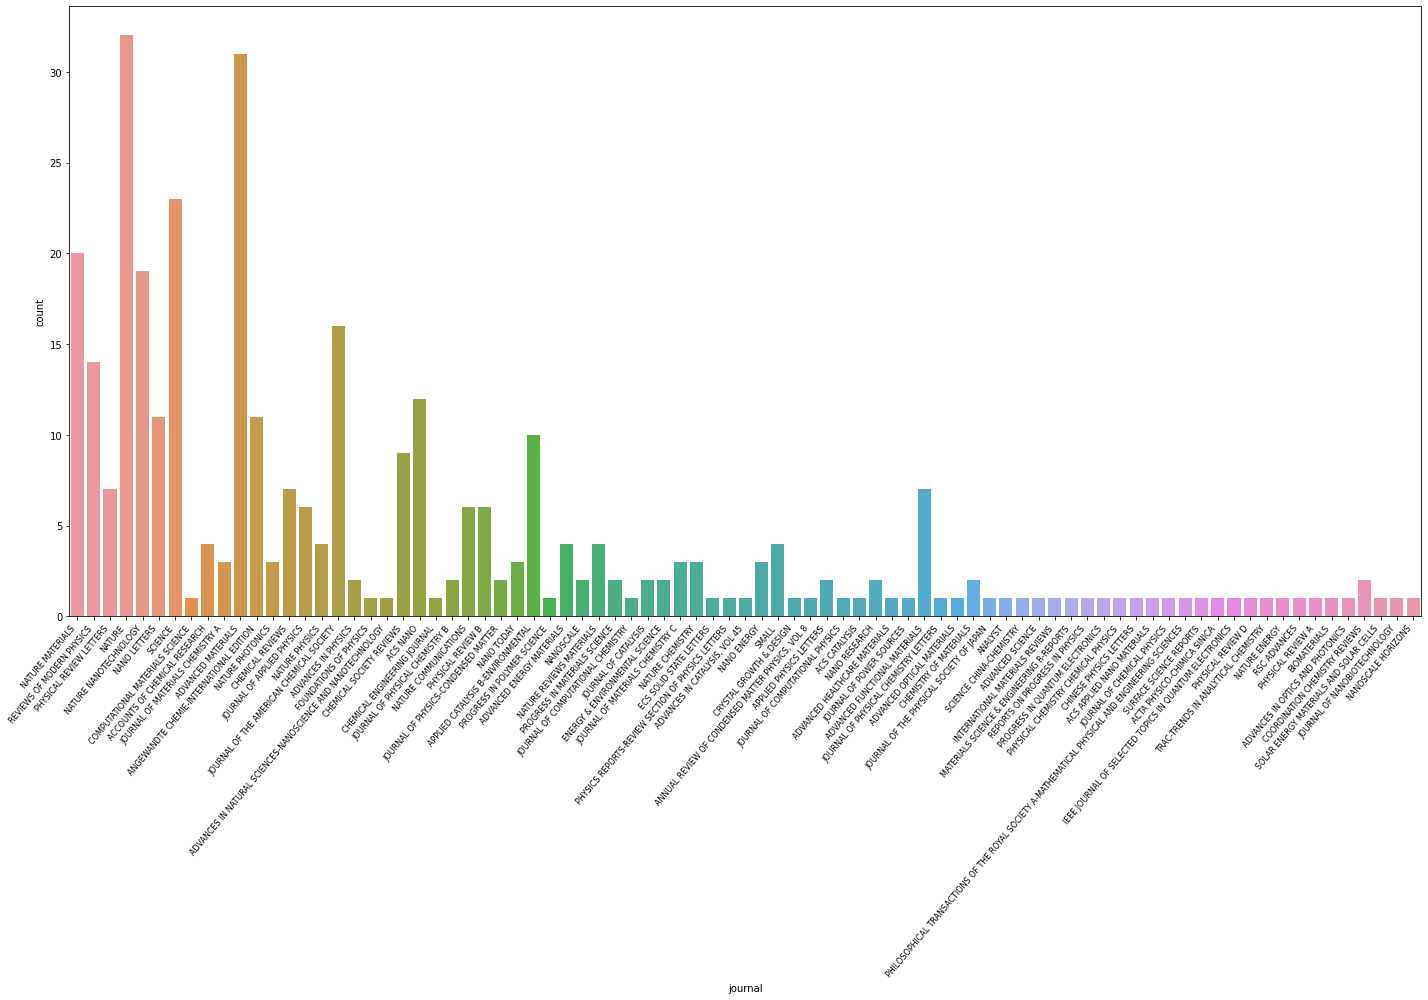

In [54]:
#################################################
# most frequent value in journal
print('Количество популярных статей в журналах:')
print('-----------------------------------------')
print(df['journal'].value_counts())
plt.figure(figsize=(20,14)) # this creates a figure 8 inch wide, 4 inch high
ax = sns.countplot(x='journal', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right", fontsize=8)
plt.tight_layout()
plt.show()

🦉 **ВЫВОД** 🦉 Результаты данного исследования показывают, что популярные или журналы с высокоцитируемыми статьями являются самыми известными научными журналами: такие как 'Nature', 'Science', 'Nature Materials', 'Nature Nanothechnology' и т.д., потому что они публикуют в основном прорывные научные результаты и большие достижения в мире науки.

Количество цитирований по принадлежности к университетам или научным центрам:
--------------------------------------------------------
                                                    total citations
 Stanford Univ, Dept Phys, Stanford, CA 94305 USA             17474
Univ Manchester, Manchester Ctr Mesosci & Nanot...            16881
TULANE UNIV, QUANTUM THEORY GRP, NEW ORLEANS, L...            12733
 Collaborat Innovat Ctr Quantum Matter, Beijing...            10662
 Tsinghua Univ, Dept Phys, Beijing 100084, Peop...            10373
...                                                             ...
 Nanyang Technol Univ, Sch Phys Math Sci, Div P...                0
 Nanyang Technol Univ, Sch Phys & Math Sci, Sin...                0
 Nanyang Technol Univ, Sch Mat Sci & Engn, Sing...                0
 Nanyang Technol Univ, Sch Mat Sci & Engn, Ctr ...                0
Zhengzhou Univ, Coll Mat Sci & Engn, Zhengzhou ...                0

[1586 rows x 1 columns]


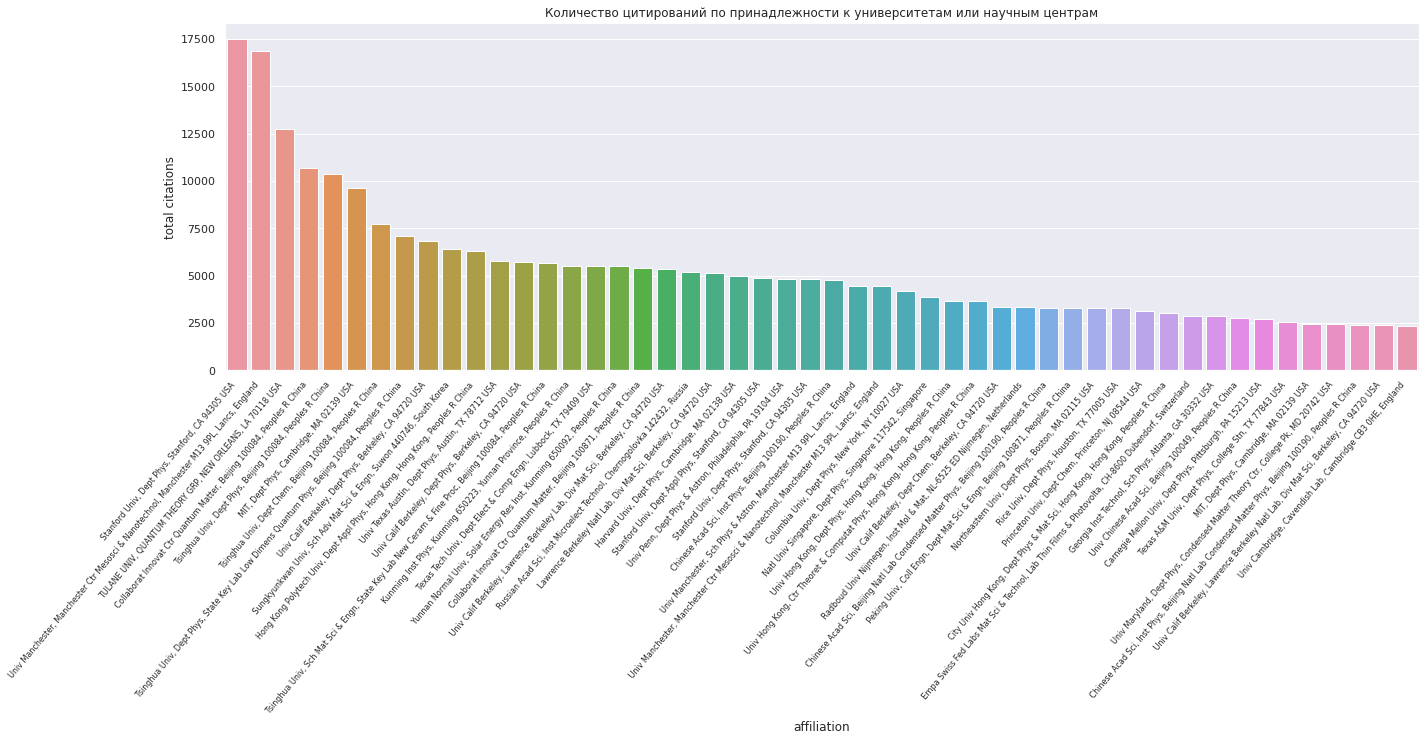

Количество статей по принадлежности к университетам или научным центрам:
--------------------------------------------------------
                                                    total papers
 Chinese Acad Sci, Inst Phys, Beijing 100190, P...             6
 City Univ Hong Kong, Dept Phys & Mat Sci, Hong...             5
 Stanford Univ, Dept Phys, Stanford, CA 94305 USA              5
 Collaborat Innovat Ctr Quantum Matter, Beijing...             5
 MIT, Dept Phys, Cambridge, MA 02139 USA                       5
...                                                          ...
 Nanyang Technol Univ, Sch Phys Math Sci, Div P...             1
 Nanyang Technol Univ, Sch Phys & Math Sci, Sin...             1
 Nanyang Technol Univ, Sch Mat Sci & Engn, Sing...             1
 Nanyang Technol Univ, Sch Mat Sci & Engn, Ctr ...             1
Zhengzhou Univ, Coll Mat Sci & Engn, Zhengzhou ...             1

[1586 rows x 1 columns]


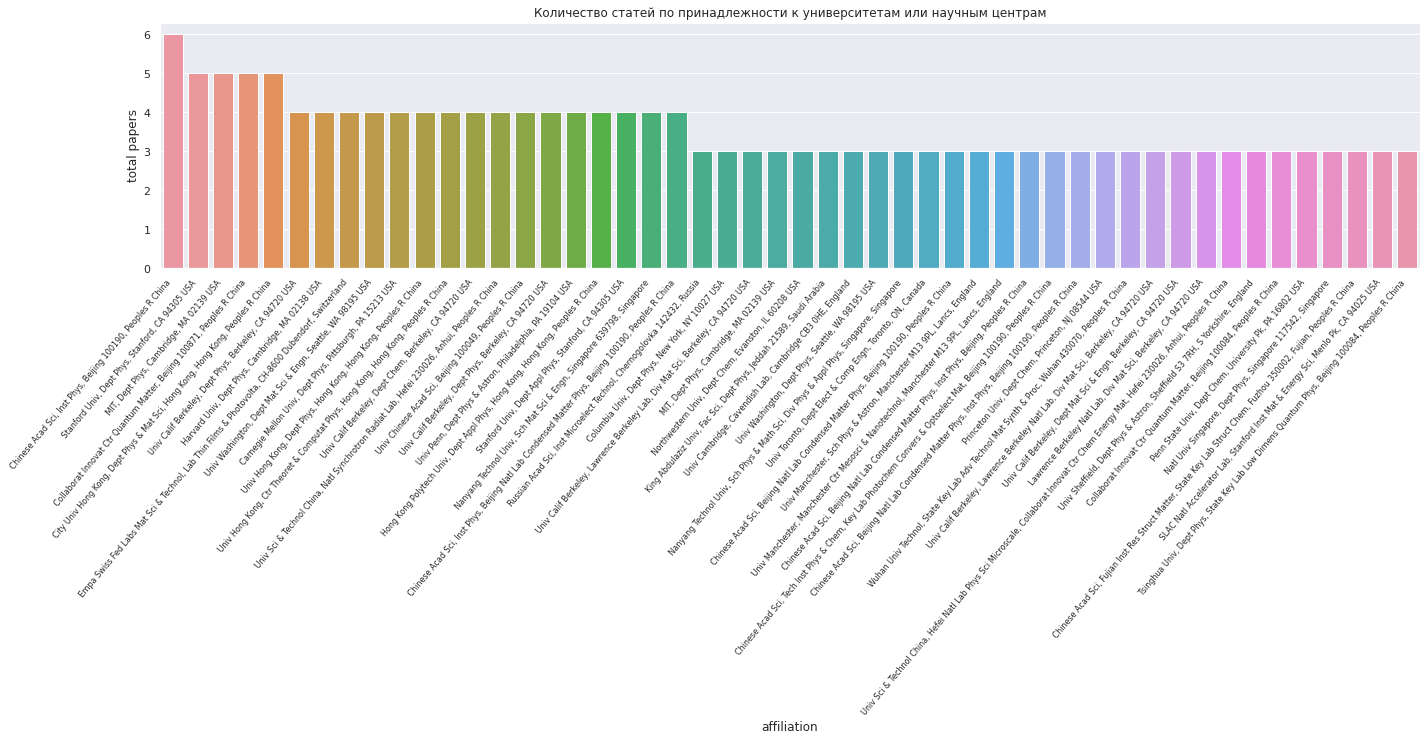

In [185]:
ctr = [len(el.split(';')) for el in df['authors_full']]
affiliation_full = []
for el in df['affiliation']:
    affiliation_full.append(el.split(';'))
dic_citations = {}
dic_counter = {}
k = 0
for el in affiliation_full:
    for i in el:
        try:
            dic_citations[i] += df['citations'][k]
            dic_counter[i] += 1
        except: 
            dic_citations[i] = 0
            dic_counter[i] = 1
    k += 1
################################################################
# most citated papers via affiliation
print('Количество цитирований по принадлежности к университетам или научным центрам:')
print('--------------------------------------------------------')
dic_citations = dict(sorted(dic_citations.items(), key=lambda item: item[1], reverse=True))
df_citations = pd.DataFrame({"total citations": dic_citations}).sort_values(by='total citations', ascending=False)
print(df_citations)
keys = list(dic_citations.keys())
vals = [dic_citations[k] for k in keys]
plt.figure(figsize=(20,10)) # this creates a figure 8 inch wide, 4 inch high
ax = sns.barplot(x=keys[:50], y=vals[:50])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right", fontsize=8)
plt.tight_layout()
ax.set(xlabel='affiliation', ylabel='total citations',title="Количество цитирований по принадлежности к университетам или научным центрам")
plt.show()
################################################################
# most frequent papers via affiliation
print('Количество статей по принадлежности к университетам или научным центрам:')
print('--------------------------------------------------------')
affiliation = []
for el in df['affiliation']:
    affiliation.extend(el.split(';'))
w = collections.Counter(affiliation)
df_counter = pd.DataFrame({"total papers": w}).sort_values(by='total papers', ascending=False)
print(df_counter)
dic_counter = dict(sorted(dic_counter.items(), key=lambda item: item[1], reverse=True))
keys = list(dic_counter.keys())
# get values in the same order as keys, and parse percentage values
vals = [dic_counter[k] for k in keys]
plt.figure(figsize=(20,10))
ax = sns.barplot(x=keys[:50], y=vals[:50])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right", fontsize=8)
plt.tight_layout()
ax.set(xlabel='affiliation', ylabel='total papers', title="Количество статей по принадлежности к университетам или научным центрам")
plt.show()

🦉 **ВЫВОД** 🦉 высоко цитируемые статьи принадлежат университетам и научным центрам из топа мирового рейтинга, таким как Institute of Physics Chinese Academy of Sciences, Stanford, MIT и т.д.

In [106]:
#добавляем еще один столбец с годом публикации
df = df.assign(year=[int(re.findall(r'\d+', el)[1]) if len(re.findall(r'\d+', el)) > 1 else int(re.findall(r'\d+', el)[0]) for el in df['date']])
df

,Unnamed: 0,title,authors,date,journal,citations,references,paper_link,authors_full,affiliation,year
0,0,The rise of graphene,"Geim, AK Novoselov, KS",Mar 2007,NATURE MATERIALS,32119,91,/wos/woscc/full-record/WOS:000244570700015,"Geim, AK; Novoselov, KS","Univ Manchester, Manchester Ctr Mesosci & Nano...",2007
1,1,The electronic properties of graphene,"Castro Neto, AH Guinea, F ... Geim, AK",Jan-mar 2009,REVIEWS OF MODERN PHYSICS,18556,440,/wos/woscc/full-record/WOS:000264764600004,"Castro Neto, AH; Guinea, F; Peres, NMR; Novose...","Boston Univ, Dept Phys, Boston, MA 02215 USA; ...",2009
2,2,Generalized gradient approximation made simple,"Perdew, JP Burke, K Ernzerhof, M",Oct 28 1996,PHYSICAL REVIEW LETTERS,126241,47,/wos/woscc/full-record/WOS:A1996VP22500044,"Perdew, JP; Burke, K; Ernzerhof, M","TULANE UNIV,QUANTUM THEORY GRP,NEW ORLEANS,LA ...",1996
3,3,Two-dimensional gas of massless Dirac fermions...,"Novoselov, KS Geim, AK ... Firsov, AA",Nov 10 2005,NATURE,16881,28,/wos/woscc/full-record/WOS:000233133500042,"Novoselov, KS; Geim, AK; Morozov, SV; Jiang, D...","Univ Manchester, Manchester Ctr Mesosci & Nano...",2005
4,4,Large-scale pattern growth of graphene films f...,"Kim, KS Zhao, Y ... Hong, BH",Feb 5 2009,NATURE,8186,30,/wos/woscc/full-record/WOS:000263064700037,"Kim, KS; Zhao, Y; Jang, H; Lee, SY; Kim, JM; K...","Sungkyunkwan Univ, Dept Chem, Suwon 440746, So...",2009
...,...,...,...,...,...,...,...,...,...,...,...
345,345,Photo/Electrochemical Applications of Metal Su...,"Zheng, LX Teng, F ... Fang, XS",Jan 2020,ADVANCED ENERGY MATERIALS,160,328,/wos/woscc/full-record/WOS:000497581000001,"Cao, L; Meziani, MJ; Sahu, S; Sun, YP","Clemson Univ, Dept Chem, Clemson, SC 29634 USA...",2020
346,346,Hydrogen storage in Pd nanocrystals covered wi...,"Li, GQ Kobayashi, H ... Kitagawa, H",Aug 2014,NATURE MATERIALS,327,24,/wos/woscc/full-record/WOS:000339647800020,"Zheng, LX; Teng, F; Ye, XY; Zheng, HJ; Fang, XS","Zhejiang Univ Technol, State Key Lab Breeding ...",2014
347,347,Photoluminescence Properties of Graphene versu...,"Cao, L Meziani, MJ ... Sun, YP",Jan 15 2013,ACCOUNTS OF CHEMICAL RESEARCH,588,42,/wos/woscc/full-record/WOS:000313667600018,"Patra, JK; Das, G; Fraceto, LF; Campos, EVR; R...","Dongguk Univ Seoul, Res Inst Biotechnol & Med ...",2013
348,348,Group 6 transition metal dichalcogenide nanoma...,"Samadi, M Sarikhani, N ... Moshfegh, AZ",Mar 2018,NANOSCALE HORIZONS,208,1221,/wos/woscc/full-record/WOS:000433439100002,"Samadi, M; Sarikhani, N; Zirak, M; Zhang, H; Z...","Sharif Univ Technol, Dept Phys, Tehran 1115591...",2018


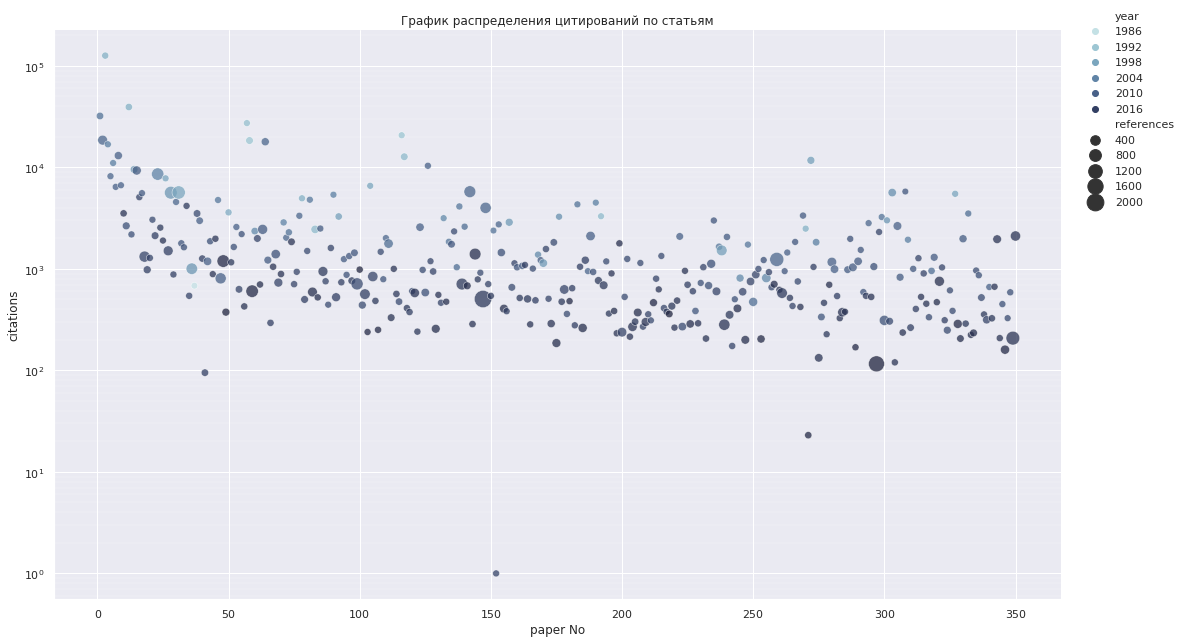

In [189]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(250,30)})
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data = df,
    alpha = 0.75,
    x=[i + 1 for i in range(350)], y = 'citations',
    hue="year", 
    size="references",
    palette=cmap, sizes=(45, 300)
)
g.set(yscale="log")
g.set(xlabel='paper No', ylabel='citations', title="График распределения цитирований по статьям")
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.fig.set_size_inches(15,9)
#plt.xticks(rotation=45, fontsize=10)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

🦉 **ВЫВОД** 🦉 данный график иллюстрирует распределение количества цитирований по статьям с дополнительной информацией о дате публикации и количестве ссылок на другие статьи в виде размера точек, логически обосновывая ее вес. Также видно из графика что 'легкие', т.е. точки более светлые поднялись выше (аналогия со сливками в молоке 😉) относительно точек потемнее, ну просто указывая на то, что более поздние статьи еще не добрались по количеству цитирований до ранних 😃

## Спасибо за проверку ДЗ! 🐈